In [1]:
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
batch_size = 512
epochs = 10
sample_size = 64
nz = 128
k = 1

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

train_dataset = datasets.MNIST(root="C:/Users/516-29/Deep/chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [22]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0,2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [24]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [25]:
optim_g = optim.Adam(generator.parameters(), lr=0.0003)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0003)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [26]:
def save_generator_image(image, path):
    save_image(image, path)

In [27]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [28]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [29]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):

            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"C:/Users/516-29/Deep/chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:10, 11.63it/s]                                                                        


Epoch 0 of 10
Generator loss: 1.68218696, Discriminator loss: 0.67810547


118it [00:10, 11.30it/s]                                                                        


Epoch 1 of 10
Generator loss: 3.97066545, Discriminator loss: 0.65518010


118it [00:10, 11.22it/s]                                                                        


Epoch 2 of 10
Generator loss: 7.51428699, Discriminator loss: 0.75173825


118it [00:11, 10.65it/s]                                                                        


Epoch 3 of 10
Generator loss: 11.23373890, Discriminator loss: 0.17220034


118it [00:12,  9.21it/s]                                                                        


Epoch 4 of 10
Generator loss: 14.10850620, Discriminator loss: 0.24941708


118it [00:13,  9.02it/s]                                                                        


Epoch 5 of 10
Generator loss: 12.89898968, Discriminator loss: 0.04957696


118it [00:10, 11.23it/s]                                                                        


Epoch 6 of 10
Generator loss: 26.84517288, Discriminator loss: 0.06056426


118it [00:10, 11.08it/s]                                                                        


Epoch 7 of 10
Generator loss: 36.02600098, Discriminator loss: 0.04300425


118it [00:10, 11.22it/s]                                                                        


Epoch 8 of 10
Generator loss: 25.77227020, Discriminator loss: 0.01539073


118it [00:13,  8.68it/s]                                                                        

Epoch 9 of 10
Generator loss: 26.08924675, Discriminator loss: 0.00452861


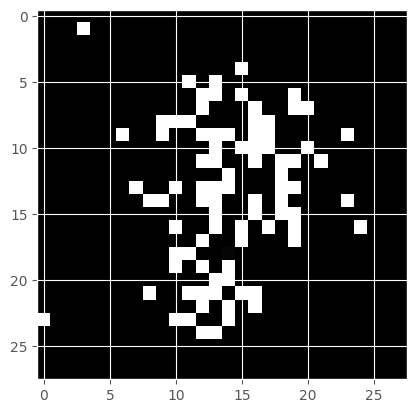

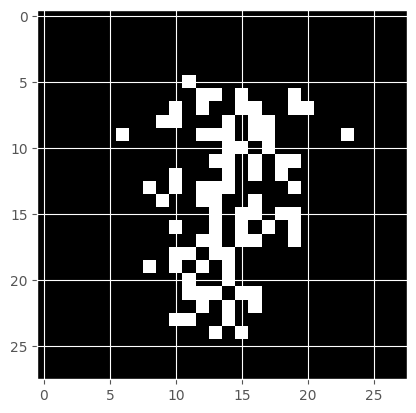

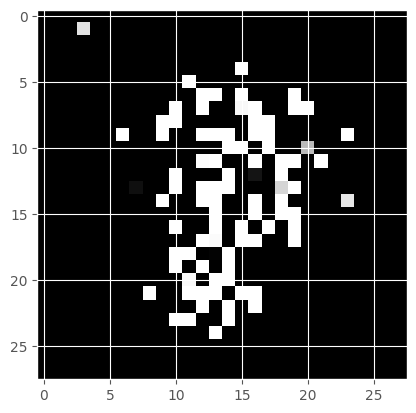

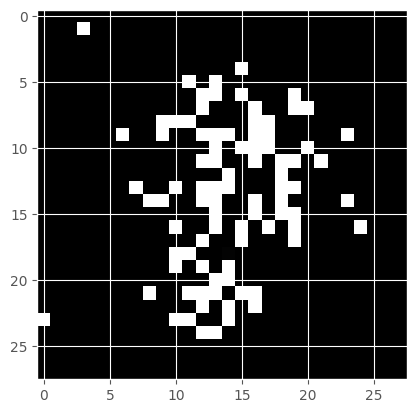

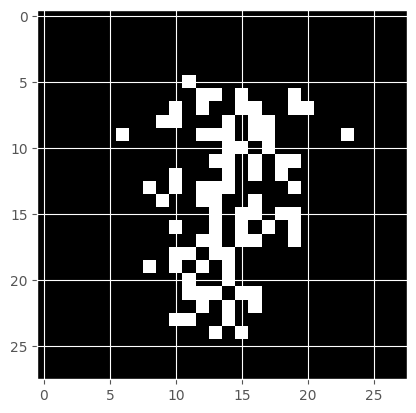

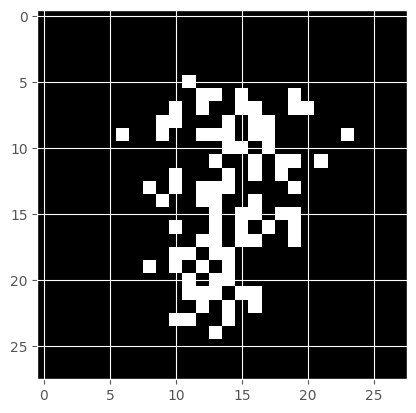

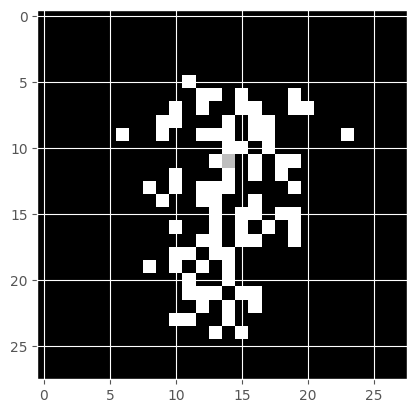

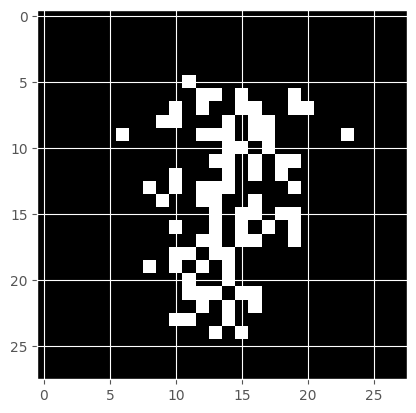

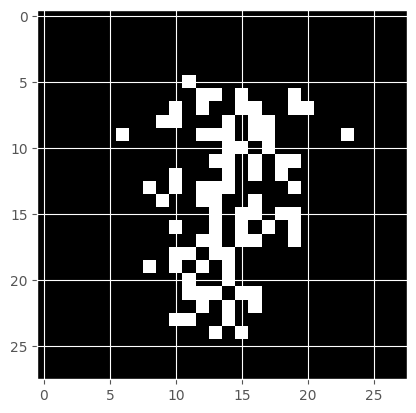

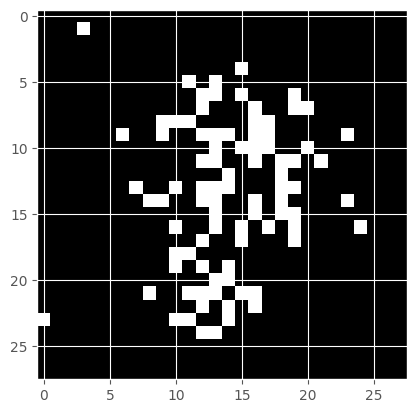

In [30]:
import numpy as np

fake_images = generator(torch.randn(b_size, nz).to(device))

for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.savefig('C:/Users/516-29/Deep/chap13/img/fake_images_img' + str(i) + '.png')
    plt.show()